In [1]:
#! pip install Geopandas
#!pip install --use-deprecated=legacy-resolver pycaret[full]
#!pip install pycaret[full]

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import os.path


import seaborn as sns
from scipy import stats


# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.pyplot import *
import imageio
from skimage.io import imread

from tqdm import tqdm

import cv2   #For image processing

import tensorflow as tf
#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


import sklearn
from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of data
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv, rgba2rgb
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage import io, color

from pycaret.datasets import get_data
from pycaret.regression import *

from scipy.signal import medfilt2d

In [3]:
#set directory for csv files
dir_name = r'C:\Users\vasan\OneDrive\EmissionsDatathon\Zeroing Methane Emissions - Dataset'
filename_suffix = 'xls'

In [46]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dall.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,source_id,source_lat,source_lon,number_overflights,source_persistence,qsource,sigma_qsource,confidence_in_persistence,Filepath,Name,candidate_id,plume_lat,plume_lon,date,source_type_y,ipcc,qplume,sigma_qplume,Uncern
0,G0001,35.249160,-119.57875,7,0.142857,96.853478,33.082042,high,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,GAO20201109t182655p0000-3_r2144_c2551-plume.png,GAO20201109t182655p0000-3,35.249160,-119.57875,2020-11-09 00:00:00,tank,1B2 Oil & Natural Gas,677.974343,231.574291,34.156793
1,G0002,35.082251,-119.30443,7,0.142857,5.364176,1.441589,low,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,GAO20201109t184716p0000-5_r7498_c8083-plume.png,GAO20201109t184716p0000-5,35.082251,-119.30443,2020-11-09 00:00:00,compressor,1B2 Oil & Natural Gas,37.549230,10.091123,26.874381
2,G0003,35.367999,-119.68495,7,0.857143,187.200884,79.748988,high,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,GAO20201109t184716p0000-A_r262_c563-plume.png,GAO20201109t184716p0000-A,35.367931,-119.68500,2020-11-09 00:00:00,pipeline,1B2 Oil & Natural Gas,138.175637,79.558328,57.577681
3,G0003,35.367999,-119.68495,7,0.857143,187.200884,79.748988,high,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,GAO20201110t204551p0000-A_r386_c362-plume.png,GAO20201110t204551p0000-A,35.368205,-119.68476,2020-11-10 00:00:00,pipeline,1B2 Oil & Natural Gas,248.282672,105.381982,42.444356
4,G0003,35.367999,-119.68495,7,0.857143,187.200884,79.748988,high,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,GAO20201113t194611p0000-A_r301_c515-plume.png,GAO20201113t194611p0000-A,35.367963,-119.68508,2020-11-13 00:00:00,pipeline,1B2 Oil & Natural Gas,167.070650,51.575281,30.870342


In [47]:
df.shape

(2995, 19)

In [9]:
def image_processing(fil):
#Open image and import it as a numpy array
    im2 = imread(fil)
    im2_rgb = color.rgba2rgb(im2)
    im2_hsv = rgb2hsv(im2_rgb)
    
    mask = im2_hsv[:,:,1] > 0.4
    
    red = im2[:,:,0]*mask
    green = im2[:,:,1]*mask
    blue = im2[:,:,2]*mask
    mask2 = np.dstack((red,green,blue))
    
    feature_matrix = np.zeros((217,217))
    
    for i in range(0,mask2.shape[0]):
        for j in range(0,mask2.shape[1]):
            feature_matrix[i][j] = ((int(mask2[i,j,0]) + int(mask2[i,j,1]) + int(mask2[i,j,2]))/3)
        
    features = np.reshape(feature_matrix, (217*217))
    
    return features

In [10]:
#pic_list = []
#name_list = []
#qplume = []
image_list = []

In [11]:
for file in tqdm(df['Filepath'].tolist()[:]):
    image_list.append(image_processing(file))

100%|██████████| 2995/2995 [02:51<00:00, 17.49it/s]


In [12]:
X = np.array(image_list)

In [13]:
X

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [43.33333333,  0.        ,  0.        , ..., 34.66666667,
        31.66666667, 29.66666667],
       [ 0.        ,  0.        ,  0.        , ..., 45.66666667,
         0.        ,  0.        ],
       [42.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [14]:
np.save('processed_128x128_image.npy',X,allow_pickle=True)

In [15]:
X.mean()

9.131522622720816

In [16]:
X.shape

(2995, 47089)

In [17]:
Y = np.array(df.qplume.tolist())

In [18]:
Y

array([677.974343 ,  37.5492297, 138.175637 , ..., 438.4123065,
       674.2734901, 475.3739425])

In [19]:
print(X.shape)
print(Y.shape)

(2995, 47089)
(2995,)


In [20]:
# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

In [21]:
img_rows, img_cols = 217, 217
input_shape = (img_rows, img_cols, 1)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_val.shape

(599, 217, 217, 1)

In [22]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

In [23]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(1797, 217, 217, 1)
(1797,)
(599, 217, 217, 1)
(599,)
(599, 217, 217, 1)
(599,)


In [24]:
#Define a Convolutional Neural Network Model

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
#model.add(Dense(n_classes, activation='softmax'))
model.add(Dense(1, activation='relu'))
learning_rate = 0.001

model.compile(loss = 'mse',
              optimizer = Adam(learning_rate))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 215, 215, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 215, 215, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 213, 213, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 213, 213, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 106, 106, 16)     0         
 )                                                               
                                                        

In [25]:
save_at = "model_regression2.hdf5"
save_best2 = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

In [26]:
np.isnan(X).any()

False

In [27]:
np.isnan(Y).any()

False

In [28]:
#Train the CNN
history = model.fit( X_train, Y_train, 
                    epochs = 15, batch_size = 100, 
                    callbacks=[save_best2], verbose=1, 
                   validation_data = (X_val, Y_val))

Epoch 1/15
18/18 [==============================] - 100s 5s/step - loss: 507877.2500 - val_loss: 520451.6875
Epoch 2/15
18/18 [==============================] - 97s 5s/step - loss: 326127.4375 - val_loss: 507114.3750
Epoch 3/15
18/18 [==============================] - 94s 5s/step - loss: 255116.9062 - val_loss: 266725.5938
Epoch 4/15
18/18 [==============================] - 91s 5s/step - loss: 233284.1250 - val_loss: 320567.7188
Epoch 5/15
18/18 [==============================] - 93s 5s/step - loss: 120238.7891 - val_loss: 317881.3438
Epoch 6/15
18/18 [==============================] - 95s 5s/step - loss: 84002.1562 - val_loss: 306946.8438
Epoch 7/15
18/18 [==============================] - 92s 5s/step - loss: 72670.0938 - val_loss: 335983.5000
Epoch 8/15
18/18 [==============================] - 91s 5s/step - loss: 57322.2266 - val_loss: 303461.4062
Epoch 9/15
18/18 [==============================] - 92s 5s/step - loss: 49084.6172 - val_loss: 248414.7969
Epoch 10/15
18/18 [============

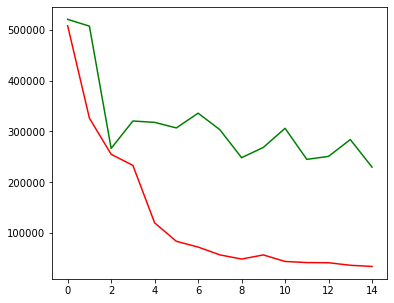

In [29]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='g')
plt.show()

In [30]:
Y_pred = np.round(model.predict(X_test))

19/19 [==============================] - 5s 264ms/step


In [31]:
# Calculate the mean squared error
mse = mean_squared_error(Y_test, Y_pred)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

r2 = r2_score(Y_test, Y_pred)
print("Test R^2 Score: {:.5f}".format(r2))

Root Mean Squared Error: 549.8701455543414
Test R^2 Score: 0.44508


In [32]:
image_sub = []

In [33]:
image_test = Path('C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Test')

In [34]:
testpaths = pd.Series(list(image_test.glob(r'**/*.png')), name='Testpath').astype(str)

In [35]:
df_testpaths = testpaths.to_frame()

In [36]:
res = os.listdir(image_test)
df_testpaths['Name'] = pd.DataFrame (res, columns = ['TestName'])

In [37]:
def image_processingsub(fil):
#Open image and import it as a numpy array
    
    
    im2 = imread(fil)
    im2 = cv2.resize(im2, (217, 217))
    im2_rgb = color.rgba2rgb(im2)
    im2_hsv = rgb2hsv(im2_rgb)
    
    mask = im2_hsv[:,:,1] > 0.4
    
    red = im2[:,:,0]*mask
    green = im2[:,:,1]*mask
    blue = im2[:,:,2]*mask
    mask2 = np.dstack((red,green,blue))
    
    feature_matrix = np.zeros((217,217))
    
    for i in range(0,mask2.shape[0]):
        for j in range(0,mask2.shape[1]):
            feature_matrix[i][j] = ((int(mask2[i,j,0]) + int(mask2[i,j,1]) + int(mask2[i,j,2]))/3)
        
    features = np.reshape(feature_matrix, (217*217))
    
    return features

In [38]:
for file in tqdm(df_testpaths['Testpath'].tolist()[:]):
    image_sub.append(image_processingsub(file))

100%|██████████| 20/20 [00:01<00:00, 19.68it/s]


In [39]:
X_sub = np.array(image_sub)

In [40]:
X_sub.shape

(20, 47089)

In [41]:
np.save('sub_image.npy',X_sub,allow_pickle=True)

In [42]:
X_sub = X_sub.reshape(X_sub.shape[0], img_rows, img_cols, 1)
X_sub = X_sub.reshape(X_sub.shape[0], img_rows, img_cols, 1)

In [43]:
Y_sub = np.round(model.predict(X_sub))

1/1 [==============================] - 0s 150ms/step


In [44]:
Y_sub

array([[201.],
       [845.],
       [144.],
       [481.],
       [282.],
       [383.],
       [674.],
       [614.],
       [186.],
       [264.],
       [166.],
       [377.],
       [430.],
       [458.],
       [388.],
       [386.],
       [549.],
       [491.],
       [462.],
       [270.]], dtype=float32)

In [45]:
np.savetxt('16e.csv', Y_sub, delimiter=',')